In [1]:
%load_ext autoreload
%autoreload 2
%run prerun.py
%matplotlib inline

device = torch.device('cuda:3')

SOLVERS:  ['dopri5', 'bdf', 'rk4', 'midpoint', 'adams', 'explicit_adams', 'fixed_adams']
{'tanh': Tanh(), 'relu': ReLU(), 'softplus': Softplus(beta=1, threshold=20), 'elu': ELU(alpha=1.0), 'swish': Swish(), 'square': Lambda(), 'identity': Lambda()}


## Data

In [2]:
import pandas as pd
df = pd.read_csv('../xz_magnet_opt.csv')
df.drop(columns='Unnamed: 0', inplace=True)

In [3]:
df.head()

,start_px,start_py,start_pz,pid,hit_x,hit_y,hit_z,hit_E,magn_len,magn_x,start_theta,start_phi,start_P
0,0.585307,-0.239336,7.729657,-13.0,-103.602234,-4.812062,-13000.0,0.865171,5.0,7.0,0.081627,-0.388161,7.755479
1,0.860176,-1.341563,3.837597,-13.0,0.000000,0.000000,0.0,0.000000,5.0,7.0,0.393601,-1.000650,4.155339
2,-1.175180,1.289560,8.766644,-13.0,-752.243652,345.333649,-13000.0,1.663801,5.0,7.0,0.196450,2.309821,8.938572
3,-1.681919,0.904257,9.074683,-13.0,-626.921997,206.969193,-13000.0,1.901685,5.0,7.0,0.207404,2.648293,9.273425
4,0.773998,3.037582,7.728539,-13.0,110.676453,959.350342,-13000.0,2.972845,5.0,7.0,0.385319,1.321298,8.340042


In [4]:
df.shape

(252000, 13)

In [5]:
x_columns = ['hit_x', 'hit_y', 'hit_E']
conditions_columns = ['magn_x', 'magn_len', 'start_pz', 
                      'start_phi', 'start_P', 'start_theta', 
                      'start_px', 'start_py']

In [6]:
x = torch.tensor(df[x_columns].values).float() 
conditions = torch.tensor(df[conditions_columns].values).float()

In [7]:
x_observation = (x[:, 2] > 0.).float().view(-1, 1)
conditions_observation = conditions.clone()

In [8]:
conditions_passed = conditions # [x[:, 2] > 0.]
x_passed = x # [x[:, 2] > 0.]
# x = torch.cat([x, (x[:, 2] != 0.).float().view(-1, 1)], dim=1)

In [9]:
x_observation.shape, conditions_observation.shape

(torch.Size([252000, 1]), torch.Size([252000, 8]))

In [10]:
x_passed.shape, conditions_passed.shape

(torch.Size([252000, 3]), torch.Size([252000, 8]))

In [ ]:
plt.scatter(x_observation.view(-1).cpu().detach().numpy(), (x_passed[:, 2].view(-1).cpu().detach().numpy()));

## Define model

Try two ways:

  1. thresholding

  2. passing observation from first model to second

In [11]:
regularization_fns = None
# regularization_fns, regularization_coeffs = create_regularization_fns()

model_observation = build_model_tabular(dims=x_observation.shape[1], 
                                condition_dim=conditions_passed.shape[1],
                                layer_type='concat_v2',
                                num_blocks=2,
                                rademacher=False,
                                nonlinearity='tanh',
                                solver='dopri5',
                                hidden_dims=(32, 32, 32),
                                bn_lag=0.01, 
                                batch_norm=True,
                                regularization_fns=regularization_fns).to(device)
sum(p.numel() for p in model_observation.parameters()  if p.requires_grad)

13326

In [12]:
model_passed = build_model_tabular(dims=x_passed.shape[1], 
                                condition_dim=conditions_passed.shape[1] + 1, # for likelohood of observation
                                layer_type='concat_v2',
                                num_blocks=3,
                                rademacher=False,
                                nonlinearity='tanh',
                                solver='dopri5',
                                hidden_dims=(64, 64, 64),
                                bn_lag=0.01, 
                                batch_norm=True,
                                regularization_fns=regularization_fns).to(device)
sum(p.numel() for p in model_passed.parameters()  if p.requires_grad)

50070

In [13]:
import torch.utils.data as pytorch_data_utils
BATCH_SIZE = 16384 * 2
dataset_observation = torch.utils.data.TensorDataset(x_observation, conditions_observation)
dataloader_observation = torch.utils.data.DataLoader(dataset_observation, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
import torch.utils.data as pytorch_data_utils
BATCH_SIZE = 16384 * 2
dataset_passed = torch.utils.data.TensorDataset(x_passed, conditions_passed)
dataloader_passed = torch.utils.data.DataLoader(dataset_passed, batch_size=BATCH_SIZE, shuffle=True)

## Training

iter 107: loss = -3.682 6.25e-05


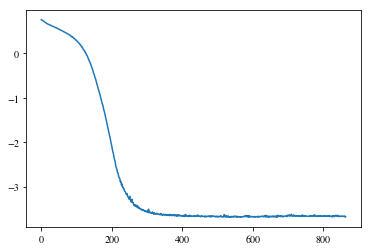

KeyboardInterrupt: 

In [16]:
%%time
from tqdm import tqdm_notebook as tqdm

trainable_parametrs = list(model_observation.parameters()) 
optimizer = torch.optim.Adam(trainable_parametrs, lr=0.5e-3)
losses = []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100)

for epoch in tqdm(range(500)):
    for x_batch, cond_batch in tqdm(dataloader_observation):
        x_batch = x_batch.to(device)
        cond_batch = cond_batch.to(device)

        loss = compute_loss(model_observation, 
                            data=x_batch + torch.randn(*x_batch.size()).float().to(device) * x_batch.std(dim=0).detach() / 100, 
                            condition=cond_batch)

        if loss != loss:
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scheduler.step(loss)

    clear_output()
    print('iter %s:' % epoch, 'loss = %.3f' % loss, optimizer.param_groups[0]['lr'])
    plt.figure()
    plt.plot(losses)
    # plt.ylim(1.1, 3)
    plt.show()

In [19]:
model_observation.eval();
sample_observation_fn, density_observation_fn = get_transforms(model_observation)

In [20]:
sample_observation_fn(torch.randn(len(cond_batch), 1).float().to(device), cond_batch)

tensor([[ 0.0085],
        [ 0.0048],
        [-0.0057],
        ...,
        [ 1.0003],
        [-0.0066],
        [ 0.0057]], device='cuda:3', grad_fn=<AddBackward0>)

iter 357: loss = 8.071 2.44140625e-07


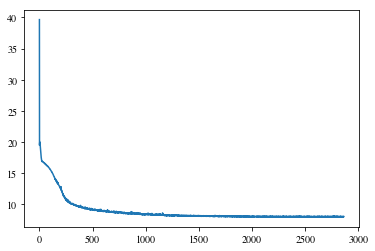

KeyboardInterrupt: 

In [21]:
%%time
from tqdm import tqdm_notebook as tqdm

trainable_parametrs = list(model_passed.parameters()) 
optimizer = torch.optim.Adam(trainable_parametrs, lr=0.5e-3)
losses = []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100)

for epoch in tqdm(range(500)):
    for x_batch, cond_batch in tqdm(dataloader_passed):
        x_batch = x_batch.to(device)
        cond_batch = cond_batch.to(device)
        
        with torch.no_grad():
            cond_ovservable = sample_observation_fn(torch.randn(len(cond_batch), 1).float().to(device), cond_batch)
            cond_batch = torch.cat([cond_batch, cond_ovservable], dim=1)
        
        loss = compute_loss(model_passed, 
                            data=x_batch + torch.randn(*x_batch.size()).float().to(device) * x_batch.std(dim=0).detach() / 100, 
                            condition=cond_batch)

        if loss != loss:
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scheduler.step(loss)

    clear_output()
    print('iter %s:' % epoch, 'loss = %.3f' % loss, optimizer.param_groups[0]['lr'])
    plt.figure()
    plt.plot(losses)
    # plt.ylim(1.1, 3)
    plt.show()

In [22]:
model_passed.eval();
sample_passed_fn, density_passed_fn = get_transforms(model_passed)

In [23]:
samples_observed = sample_observation_fn(torch.randn((len(conditions), 1)).float().to(device), conditions.to(device))

In [24]:
samples = sample_passed_fn(torch.randn((len(conditions), 3)).float().to(device), torch.cat([conditions.to(device), samples_observed], dim=1))

In [25]:
torch.unique(conditions[:, 0])

tensor([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [26]:
torch.unique(conditions[:, 1])

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.])

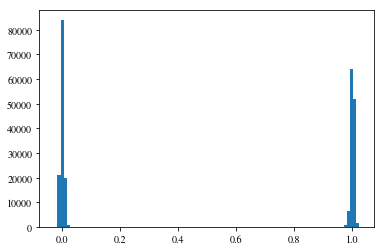

In [27]:
plt.hist(samples_observed.view(-1).detach().cpu().numpy(), bins=100);

In [39]:
mask_raw = ((conditions[:, 0] == 8) & (conditions[:, 1] == 9)).detach().cpu().numpy()
mask_energy = ((conditions[:, 0] == 8) & (conditions[:, 1] == 9) & (samples[:, 2].view(-1) > 0.1).cpu()).detach().cpu().numpy()
mask_hierarchical = ((conditions[:, 0] == 8) & (conditions[:, 1] == 9) & (samples_observed.view(-1) > 0.1).cpu()).detach().cpu().numpy()

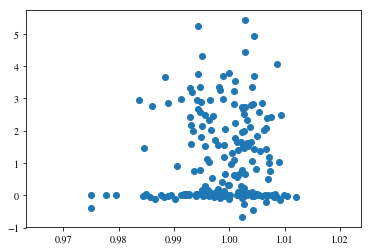

In [41]:
plt.scatter(samples_observed[mask_hierarchical].view(-1).cpu().detach().numpy(), (samples[mask_hierarchical][:, 2].view(-1).cpu().detach().numpy()));

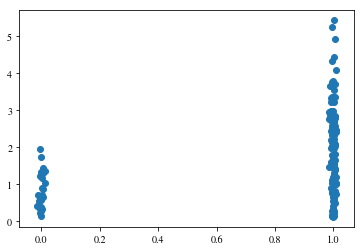

In [42]:
plt.scatter(samples_observed[mask_energy].view(-1).cpu().detach().numpy(), (samples[mask_energy][:, 2].view(-1).cpu().detach().numpy()));

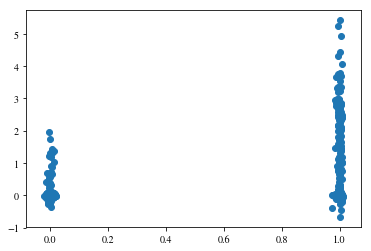

In [43]:
plt.scatter(samples_observed[mask_raw].view(-1).cpu().detach().numpy(), (samples[mask_raw][:, 2].view(-1).cpu().detach().numpy()));

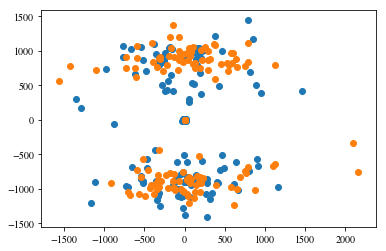

In [52]:
plt.scatter(samples[mask_hierarchical][:, 0].detach().cpu(), samples[mask_hierarchical][:, 1].detach().cpu())
plt.scatter(x[:, 0][mask_hierarchical], x[:, 1][mask_hierarchical])

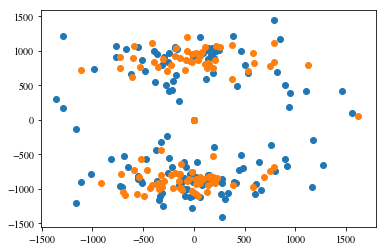

In [53]:
plt.scatter(samples[mask_energy][:, 0].detach().cpu(), samples[mask_energy][:, 1].detach().cpu())
plt.scatter(x[:, 0][mask_energy], x[:, 1][mask_energy])

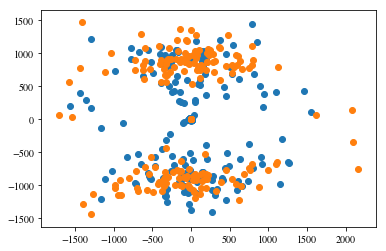

In [54]:
plt.scatter(samples[mask_raw][:, 0].detach().cpu(), samples[mask_raw][:, 1].detach().cpu())
plt.scatter(x[:, 0][mask_raw], x[:, 1][mask_raw])

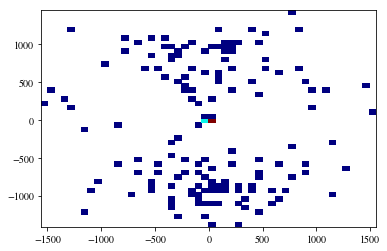

In [59]:
my_cmap = plt.cm.jet
my_cmap.set_under('white')



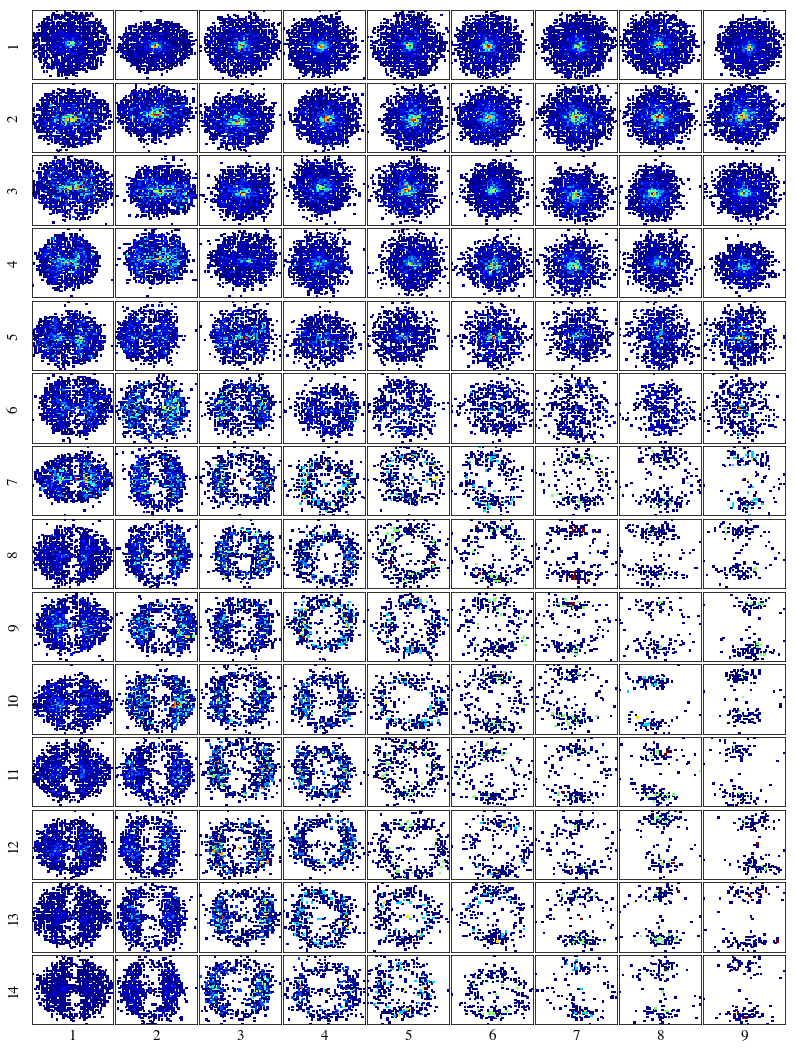

In [70]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(15,20))
gs1 = gridspec.GridSpec(15, 10)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(1,15):
    for j in range(1,10):
        ax = plt.subplot(gs1[i, j])
        mask_energy = ((conditions[:, 0] == j) & (conditions[:, 1] == i) & (samples[:, 2].view(-1) > 0.1).cpu()).detach().cpu().numpy()
        plt.hist2d(x=samples[mask_energy][:, 0].detach().cpu().numpy(), 
                   y=samples[mask_energy][:, 1].detach().cpu().numpy(),
                   bins=50, cmap=my_cmap, cmin=1e-10);
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        # ax.set_aspect('equal')
        if j == 1:
            ax.set_ylabel(i, fontsize=15)
        if i == 14:
            ax.set_xlabel(j, fontsize=15)
        plt.tick_params(
            axis='both',       
            which='both',      
            bottom=False,      
            left=False,
            labelbottom=False)
        
fig.tight_layout()
fig.subplots_adjust(top=0.9) 
plt.show()

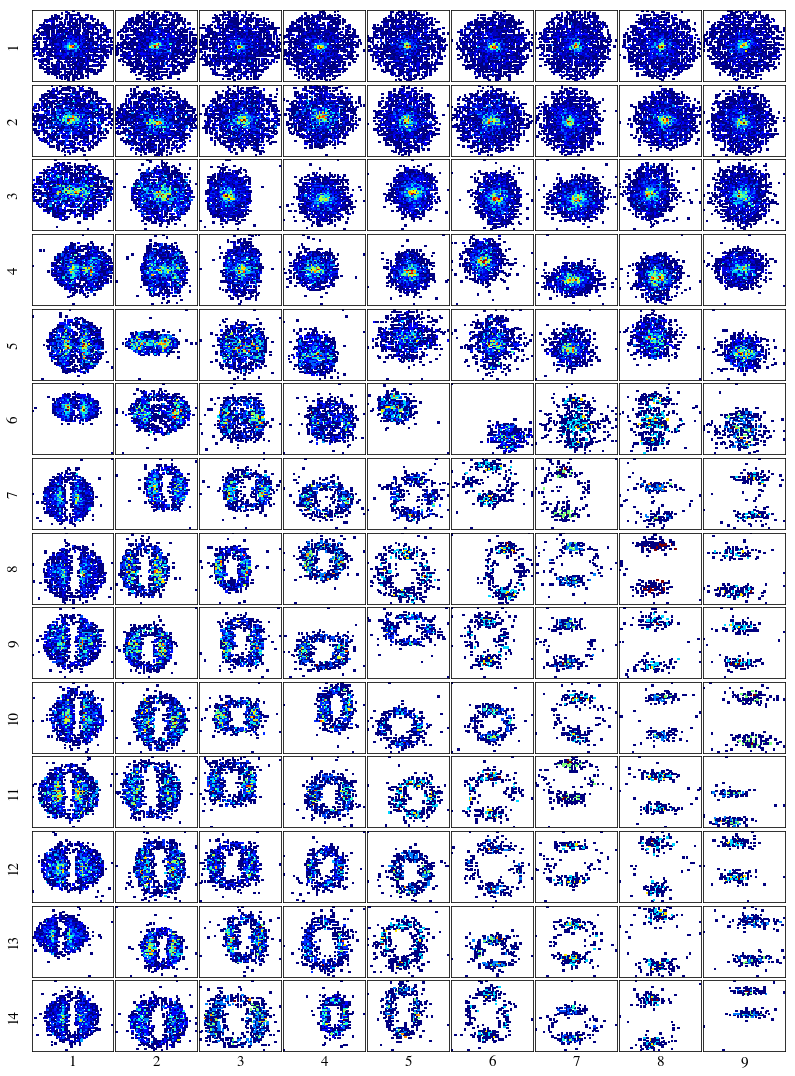

In [71]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15,20))
gs1 = gridspec.GridSpec(15, 10)
gs1.update(wspace=0.025, hspace=0.05)

for i in range(1,15):
    for j in range(1,10):
        ax = plt.subplot(gs1[i, j])
        mask_energy = ((conditions[:, 0] == j) & (conditions[:, 1] == i) & (x[:, 2].view(-1) > 0.1).cpu()).detach().cpu().numpy()
        plt.hist2d(x=x[mask_energy][:, 0].detach().cpu().numpy(), 
                   y=x[mask_energy][:, 1].detach().cpu().numpy(),
                   bins=50, cmap=my_cmap, cmin=1e-10);
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        # ax.set_aspect('equal')
        if j == 1:
            ax.set_ylabel(i, fontsize=15)
        if i == 14:
            ax.set_xlabel(j, fontsize=15)
        plt.tick_params(
            axis='both',       
            which='both',      
            bottom=False,      
            left=False,
            labelbottom=False)
        
fig.tight_layout()
fig.subplots_adjust(top=0.9) 
plt.show()